<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/SPI1_regression/TrainRegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
![[ -e SPI1_negatives.tsv.gz ]] || wget -O SPI1_negatives.tsv.gz http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_negatives.tsv.gz -O SPI1_negatives.tsv.gz
![[ -e SPI1_positives_regression_labels.tsv.gz ]] || wget -O SPI1_positives_regression_labels.tsv.gz http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_positives_regression_labels.tsv.gz

#download hg38 fasta file
![[ -e hg38.fa ]] || wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O hg38.fa.gz
![[ -e hg38.fa ]] || gunzip hg38.fa.gz

#install pyfaidx and prepare an index for hg38.fa
!pip install pyfaidx
from pyfaidx import Fasta
Fasta("hg38.fa") #this will build the index if it does not exist

--2019-09-05 07:00:55--  http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_negatives.tsv.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242572693 (231M) [application/x-gzip]
Saving to: ‘SPI1_negatives.tsv.gz’

SPI1_negatives.tsv. 100%[===================>] 231.33M  5.38MB/s    in 67s     

2019-09-05 07:02:02 (3.46 MB/s) - ‘SPI1_negatives.tsv.gz’ saved [242572693/242572693]

--2019-09-05 07:02:03--  http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_positives_regression_labels.tsv.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4179271 (4.0M) [application/x-gzip]
Saving to: ‘

Fasta("hg38.fa")

In [0]:
![[ -e noheader_SPI1_negatives.tsv.gz ]] || zcat SPI1_negatives.tsv.gz | grep -v 'START' | gzip -c > noheader_SPI1_negatives.tsv.gz
![[ -e noheader_SPI1_positives_regression_labels.tsv.gz ]] || zcat SPI1_positives_regression_labels.tsv.gz | grep -v 'START' | gzip -c > noheader_SPI1_positives_regression_labels.tsv.gz

!zcat noheader_SPI1_negatives.tsv.gz | egrep -v -w 'chr1|chr8|chr21|chr22' | gzip -c > train_SPI1_negatives.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -v -w 'chr1|chr8|chr21|chr22' | gzip -c > train_SPI1_positives_regression_labels.tsv.gz
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_SPI1_coords.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr1|chr8|chr21' | gzip -c >> test_SPI1_coords.tsv.gz

In [0]:
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr1' | gzip -c > minitrain_SPI1_negatives.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr1' | gzip -c > minitrain_SPI1_positives_regression_labels.tsv.gz

In [5]:
#num negs in validation set
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr22'  | wc -l

995472


In [6]:
#num pos in validation set
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr22' | wc -l

6127


In [7]:
#combine the positives and negatives in the validation set; subsample the
# validation set for speed of calculation
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr22' | perl -ne 'if ($.%25==0) {print $_}' | gzip -c > negsubsampled_valid.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr22' | gzip -c >> negsubsampled_valid.tsv.gz
!zcat negsubsampled_valid.tsv.gz | wc -l

45945


In [8]:
pip install tqdm

In [9]:
!git clone https://github.com/kundajelab/seqdataloader.git

Cloning into 'seqdataloader'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1124 (delta 57), reused 89 (delta 31), pack-reused 1003
Receiving objects: 100% (1124/1124), 3.92 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (683/683), done.


In [10]:
%cd /content/seqdataloader
!git checkout downsamplenegatives
!git pull
!pip uninstall seqdataloader
!pip install .
%cd /content

/content/seqdataloader
Branch 'downsamplenegatives' set up to track remote branch 'downsamplenegatives' from 'origin'.
Switched to a new branch 'downsamplenegatives'
Already up to date.
Processing /content/seqdataloader
     |████████████████████████████████| 194kB 6.8MB/s 
     |████████████████████████████████| 12.5MB 38.1MB/s 
     |████████████████████████████████| 71kB 27.0MB/s 
     |████████████████████████████████| 3.2MB 34.7MB/s 
     |████████████████████████████████| 51kB 24.6MB/s 
  Created wheel for seqdataloader: filename=seqdataloader-0.126-cp36-none-any.whl size=27501 sha256=a736ca6a900d8551cda69e05128e410e8652ea9e91f8fccc4b3ca4fdcd6e8eda
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxpjrksr/wheels/c2/db/13/112d41662f69fb8c7986c218293570cc1550fc21eed966e31b
  Created wheel for deeptools: filename=deepTools-3.3.0-cp36-none-any.whl size=209149 sha256=fa4c46dde363963982d8828f3b59ddfd732680e9607feb07e15d61bbe5671aa1
  Stored in directory: /root/.cache/pip/wheels/de/22/

In [1]:
from seqdataloader.batchproducers import coordbased
import numpy as np

regression_coordstovals = coordbased.coordstovals.lookup.SimpleLookup(
    lookup_file="noheader_SPI1_positives_regression_labels.tsv.gz")
classification_coordstovals = coordbased.coordstovals.lookup.SimpleLookup(
    lookup_file="noheader_SPI1_positives_regression_labels.tsv.gz",
    transformation=lambda x: 1.0 if x > 0 else 0.0)
targets_coordstovals = coordbased.coordstovals.core.CoordsToValsJoiner(
                        [classification_coordstovals, regression_coordstovals])

input_coordstovals = coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
    genome_fasta_path="hg38.fa")

valid_batchproducer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
    bed_file="negsubsampled_valid.tsv.gz",
    batch_size=64,
    shuffle_before_epoch=False,
    seed=None)

train_batchproducer = (
  coordbased.coordbatchproducers.DownsampleNegativesCoordsBatchProducer(
    pos_bed_file="minitrain_SPI1_positives_regression_labels.tsv.gz",
    neg_bed_file="minitrain_SPI1_negatives.tsv.gz",
    target_proportion_positives=0.5,
    batch_size=64,
    shuffle_before_epoch=True,
    seed=1234))

train_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=train_batchproducer,
    inputs_coordstovals=input_coordstovals,
    targets_coordstovals=targets_coordstovals,
    coordsbatch_transformer=\
      coordbased.coordbatchtransformers.ReverseComplementAugmenter())

valid_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=valid_batchproducer,
    inputs_coordstovals=input_coordstovals,
    targets_coordstovals=targets_coordstovals)


Using TensorFlow backend.


Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Reading in positive bed file
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Got 31302  coords in positive bed file
Reading in negative bed file
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Got 4881439  coords in negative bed file
The target proportion of positives of 0.5 requires the negative set to be subsampled by a factor of 156 which will result in a #neg of 31291
Using an offset of  0  before striding


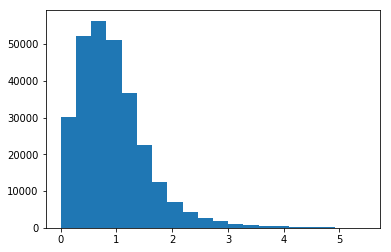

In [2]:
vals = list(regression_coordstovals.lookup.values())
from matplotlib import pyplot as plt
plt.hist(np.array(vals).squeeze(), bins=20)
plt.show()

In [3]:
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback
from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score
from keras.constraints import max_norm


def predict_on_datagenerator(datagenerator, model, key=None):
  total_positives_preds = []
  total_positives_labels = []
  total_negatives_preds = []
  total_negatives_labels = []
  for batch_num in tqdm(range(len(datagenerator))):
    batch_inputs, batch_labels = datagenerator[batch_num]
    batch_preds = model.predict(batch_inputs)
    if (key is not None):
      batch_preds = batch_preds[key]
      batch_labels = batch_labels[key]
    batch_preds, batch_labels = (np.squeeze(batch_preds),
                                 np.squeeze(batch_labels))
    assert len(batch_labels.shape)==1
    positives_mask = batch_labels > 0.0
    negatives_mask = positives_mask==False
    total_positives_preds.extend(batch_preds[positives_mask])
    total_positives_labels.extend(batch_labels[positives_mask])
    total_negatives_preds.extend(batch_preds[negatives_mask])
    total_negatives_labels.extend(batch_labels[negatives_mask])

  total_positives_preds = np.array(total_positives_preds)
  total_positives_labels = np.array(total_positives_labels)
  total_negatives_preds = np.array(total_negatives_preds)
  total_negatives_labels = np.array(total_negatives_labels)
  
  return (total_positives_preds, total_positives_labels,
          total_negatives_preds, total_negatives_labels)


class SeparatePositivesNegativesMseHistory(Callback):
  
  def __init__(self, datasetname, datagenerator, interval_of_evaluation):
    self.datasetname = datasetname
    self.datagenerator = datagenerator
    self.interval_of_evaluation = interval_of_evaluation
    self.batches_since_last_eval = 0
    self.positives_mse_history = []
    self.recentered_positives_mse_history = []
    self.positives_spearman_history = []
    self.auroc_history = []
    self.negatives_mse_history = []
    self.recentered_negatives_mse_history = []
    
  def on_batch_end(self, *args, **kwargs):
    
    self.batches_since_last_eval =(
      (1+self.batches_since_last_eval)%self.interval_of_evaluation)
    
    if (self.batches_since_last_eval==0):   
      
      (total_positives_preds, total_positives_labels,
        total_negatives_preds, total_negatives_labels) = (
        predict_on_datagenerator(datagenerator=self.datagenerator,
                                 model=self.model,
                                 key=1))
         
      num_positives = len(total_positives_preds)
      num_negatives = len(total_negatives_preds)
      
      positives_mse = np.mean(
          np.square(total_positives_preds-total_positives_labels))
      negatives_mse = np.mean(
          np.square(total_negatives_preds-total_negatives_labels))
      recentered_positives_mse = np.mean(
          np.square((total_positives_preds-np.mean(total_positives_preds))
                    -(total_positives_labels-np.mean(total_positives_labels))))
      recentered_negatives_mse = np.mean(
          np.square((total_negatives_preds-np.mean(total_negatives_preds))
                    -(total_negatives_labels-np.mean(total_negatives_labels))))
      
      positives_spearman = spearmanr(a=total_positives_preds,
                                     b=total_positives_labels)[0]
      auroc = roc_auc_score(y_true=[1 for x in total_positives_preds]+
                                   [0 for x in total_negatives_preds],
                            y_score=list(total_positives_preds)
                                    +list(total_negatives_preds))
      
      self.auroc_history.append(auroc)
      self.positives_spearman_history.append(positives_spearman)
      self.positives_mse_history.append(positives_mse)
      self.recentered_positives_mse_history.append(recentered_positives_mse)
      self.negatives_mse_history.append(negatives_mse)
      self.recentered_negatives_mse_history.append(recentered_negatives_mse)

      print("\n"+self.datasetname+": Mean mse over",num_positives,
            "positives is",positives_mse,
            "recentered",recentered_positives_mse)
      print(self.datasetname+": positives spearman",positives_spearman)
      print(self.datasetname+": auroc",auroc)
      print(self.datasetname+": Mean mse over",num_negatives,
            "negatives is",negatives_mse,
            "recentered",recentered_negatives_mse)
    

class CatchOverfittingOnPositives(SeparatePositivesNegativesMseHistory):
  
  def __init__(self, validation_data, interval_of_evaluation, patience):
    super(CatchOverfittingOnPositives, self).__init__(
        datasetname="validation set",
        datagenerator=validation_data,
        interval_of_evaluation=interval_of_evaluation)
    self.patience = patience
    self.rounds_waited = 0
    self.best_positives_loss = None
    self.best_weights = None
    self.stopped_epoch = None
    
  def on_batch_end(self, *args, **kwargs):
    
    super(CatchOverfittingOnPositives, self).on_batch_end(*args, **kwargs)
    if (self.batches_since_last_eval==0):  
      auroc = self.auroc_history[-1]
      if (self.best_positives_loss is None or
          self.best_positives_loss <= auroc):
        print("New best!")
        self.best_weights = self.model.get_weights()
        self.best_positives_loss = auroc
        self.rounds_waited = 0
      else:
        self.rounds_waited += 1
        if (self.rounds_waited >= self.patience):
          self.model.stop_training = True
          print("Restoring weights from the best round")
          self.model.set_weights(self.best_weights)
    

def manual_mse(y_true, y_pred):
  return K.mean(K.square(y_pred-y_true), axis=-1)

def mse_on_positives(y_true, y_pred):
  the_mask = tf.greater(y_true, 0.0)
  masked_y_true = tf.boolean_mask(y_true, the_mask)
  masked_y_pred = tf.boolean_mask(y_pred, the_mask)
  return K.mean(K.square(masked_y_pred-masked_y_true),axis=-1)

def mse_on_negatives(y_true, y_pred):
  the_mask = tf.equal(y_true, 0.0)
  masked_y_true = tf.boolean_mask(y_true, the_mask)
  masked_y_pred = tf.boolean_mask(y_pred, the_mask)
  return K.mean(K.square(masked_y_pred-masked_y_true),axis=-1)


def get_model(num_conv_filters,
              conv_filter_length,
              pool_length_and_stride,
              num_dense_units,
              adam_lr):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              kernel_constraint=max_norm(7.0,axis=-1),
              padding="same")(input)
  conv1batchnorm = keras.layers.normalization.BatchNormalization()(conv1)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1batchnorm)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2batchnorm = keras.layers.normalization.BatchNormalization()(conv2)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2batchnorm)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3batchnorm = keras.layers.normalization.BatchNormalization()(conv3)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3batchnorm)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  flatten = keras.layers.core.Flatten()(avgpool)
  dense1 = keras.layers.core.Dense(units=num_dense_units)(flatten)
  dense1batchnorm = keras.layers.normalization.BatchNormalization()(dense1)
  dense1relu = keras.layers.core.Activation(activation="relu")(dense1batchnorm)
  dense1dropout = keras.layers.core.Dropout(0.2)(dense1relu)
  
  classif_output =\
    keras.layers.core.Activation(activation="sigmoid",
                                 name="classif_output")(
          keras.layers.core.Dense(units=1)(dense1dropout))
  regression_output_premult =\
    keras.layers.core.Activation(activation="relu")(
          keras.layers.core.Dense(units=1)(dense1dropout))
  regression_output = keras.layers.Multiply(name="regression_output")(
                          [classif_output, regression_output_premult])
  
  conv_model = keras.models.Model(inputs=input,
                                  outputs=[classif_output, regression_output])
  conv_model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                     loss=["binary_crossentropy", "mse"])
  return conv_model

conv_model = get_model(num_conv_filters=50,
                       conv_filter_length=15,
                       pool_length_and_stride=40,
                       num_dense_units=30,
                       adam_lr=0.0001)

conv_model.summary()
early_stopping_callback = CatchOverfittingOnPositives(
                              validation_data=valid_batch_generator,
                              interval_of_evaluation=len(train_batch_generator),
                              patience=20)
fit_history = conv_model.fit_generator(
  #x=train_batch_generator[0][0],
  #y=train_batch_generator[0][1],
  generator=train_batch_generator,
  epochs=300,
  callbacks=[early_stopping_callback,
             SeparatePositivesNegativesMseHistory(
              datasetname="minitrain",
              datagenerator=train_batch_generator,
              interval_of_evaluation=len(train_batch_generator))]
)
#the callback isn't triggered if the upper epoch limit is hit,
# so make sure the set the weights from the best epoch at the end
conv_model.set_weights(early_stopping_callback.best_weights)

W0905 07:46:45.353981 139929457473408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 07:46:45.376100 139929457473408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 07:46:45.378120 139929457473408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 07:46:45.486297 139929457473408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0905 07:46:45.738223 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 50)     3050        sequence[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1000, 50)     200         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1000, 50)     0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  1  before striding


  0%|          | 1/979 [00:00<02:30,  6.50it/s]


validation set: Mean mse over 6127 positives is 0.7199011896061133 recentered 0.3774897355693348
validation set: positives spearman 0.2682076136056427
validation set: auroc 0.7938805238553881
validation set: Mean mse over 39818 negatives is 0.06979831040004127 recentered 0.03528375063179401
New best!


100%|██████████| 979/979 [02:33<00:00,  6.36it/s]



minitrain: Mean mse over 62604 positives is 0.736530029236563 recentered 0.38283661265962626
minitrain: positives spearman 0.27610725841642925
minitrain: auroc 0.7755056427214664
minitrain: Mean mse over 62584 negatives is 0.05359276631200316 recentered 0.022744326762472997
979/979 [==============================] - 370s 378ms/step - loss: 1.0155 - classif_output_loss: 0.6071 - regression_output_loss: 0.4084
Epoch 2/300
978/979 [============================>.] - ETA: 0s - loss: 0.8933 - classif_output_loss: 0.5362 - regression_output_loss: 0.3571

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  2  before striding


  0%|          | 1/979 [00:00<02:34,  6.32it/s]


validation set: Mean mse over 6127 positives is 0.4393842062651772 recentered 0.3978288125088326
validation set: positives spearman 0.20649261946357264
validation set: auroc 0.8294819074905722
validation set: Mean mse over 39818 negatives is 0.24481490057595995 recentered 0.10054196080242085
New best!


100%|██████████| 979/979 [02:34<00:00,  6.34it/s]



minitrain: Mean mse over 62604 positives is 0.42200040313901255 recentered 0.3924900792740344
minitrain: positives spearman 0.250737152318299
minitrain: auroc 0.8199646974957638
minitrain: Mean mse over 62584 negatives is 0.25553891675598506 recentered 0.07564362607202421
979/979 [==============================] - 367s 375ms/step - loss: 0.8931 - classif_output_loss: 0.5362 - regression_output_loss: 0.3569
Epoch 3/300
978/979 [============================>.] - ETA: 0s - loss: 0.8161 - classif_output_loss: 0.4853 - regression_output_loss: 0.3308

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  3  before striding


  0%|          | 1/979 [00:00<02:31,  6.46it/s]


validation set: Mean mse over 6127 positives is 1.3068882168661833 recentered 0.3904795518142377
validation set: positives spearman 0.1472758460560237
validation set: auroc 0.864201682696255
validation set: Mean mse over 39818 negatives is 0.00034541103730237826 recentered 0.00030299651199787203
New best!


100%|██████████| 979/979 [02:34<00:00,  6.34it/s]



minitrain: Mean mse over 62604 positives is 1.2492303026493115 recentered 0.39422057505976477
minitrain: positives spearman 0.1550183977562814
minitrain: auroc 0.8711997009186863
minitrain: Mean mse over 62584 negatives is 0.00022465608030598034 recentered 0.00016814363933512636
979/979 [==============================] - 365s 373ms/step - loss: 0.8161 - classif_output_loss: 0.4853 - regression_output_loss: 0.3309
Epoch 4/300
978/979 [============================>.] - ETA: 0s - loss: 0.7217 - classif_output_loss: 0.4194 - regression_output_loss: 0.3022

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  4  before striding


  0%|          | 1/979 [00:00<02:30,  6.51it/s]


validation set: Mean mse over 6127 positives is 0.6972561992762683 recentered 0.4083022187722024
validation set: positives spearman 0.2113135692153624
validation set: auroc 0.8497962981443158
validation set: Mean mse over 39818 negatives is 1.0401914122366398 recentered 0.3183689151731719


100%|██████████| 979/979 [02:34<00:00,  6.32it/s]



minitrain: Mean mse over 62604 positives is 0.7626906665814656 recentered 0.3697723204043847
minitrain: positives spearman 0.2944675510030021
minitrain: auroc 0.8708772575335065
minitrain: Mean mse over 62584 negatives is 1.1927269798814635 recentered 0.19468157449829795
979/979 [==============================] - 367s 374ms/step - loss: 0.7217 - classif_output_loss: 0.4194 - regression_output_loss: 0.3023
Epoch 5/300
978/979 [============================>.] - ETA: 0s - loss: 0.6415 - classif_output_loss: 0.3619 - regression_output_loss: 0.2796

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  5  before striding


  0%|          | 1/979 [00:00<02:28,  6.58it/s]


validation set: Mean mse over 6127 positives is 1.2881355784656445 recentered 0.385212132395503
validation set: positives spearman 0.15984681117177918
validation set: auroc 0.9034410570872072
validation set: Mean mse over 39818 negatives is 0.00019412317306302513 recentered 0.00018964300776805432
New best!


100%|██████████| 979/979 [02:33<00:00,  6.38it/s]



minitrain: Mean mse over 62604 positives is 1.2387893696611976 recentered 0.3884372042157002
minitrain: positives spearman 0.19955663272037533
minitrain: auroc 0.9373026796130146
minitrain: Mean mse over 62584 negatives is 0.00014083632685018112 recentered 0.00013690614431267572
979/979 [==============================] - 365s 373ms/step - loss: 0.6416 - classif_output_loss: 0.3618 - regression_output_loss: 0.2797
Epoch 6/300
978/979 [============================>.] - ETA: 0s - loss: 0.5732 - classif_output_loss: 0.3151 - regression_output_loss: 0.2581

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  6  before striding


  0%|          | 1/979 [00:00<02:37,  6.22it/s]


validation set: Mean mse over 6127 positives is 0.4206341603136381 recentered 0.40214601464717675
validation set: positives spearman 0.26230026005688684
validation set: auroc 0.89299453733682
validation set: Mean mse over 39818 negatives is 0.15619515479722995 recentered 0.09494485076997507


100%|██████████| 979/979 [02:33<00:00,  6.36it/s]



minitrain: Mean mse over 62604 positives is 0.33715438829237826 recentered 0.33237134451285005
minitrain: positives spearman 0.3949804646397506
minitrain: auroc 0.9339703686408525
minitrain: Mean mse over 62584 negatives is 0.12655977794478257 recentered 0.0716629916011962
979/979 [==============================] - 365s 373ms/step - loss: 0.5732 - classif_output_loss: 0.3152 - regression_output_loss: 0.2580
Epoch 7/300
978/979 [============================>.] - ETA: 0s - loss: 0.5111 - classif_output_loss: 0.2733 - regression_output_loss: 0.2378

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  7  before striding


  0%|          | 1/979 [00:00<02:44,  5.95it/s]


validation set: Mean mse over 6127 positives is 0.4538234851368858 recentered 0.44853916532846183
validation set: positives spearman 0.2564570818091169
validation set: auroc 0.9014969658379444
validation set: Mean mse over 39818 negatives is 0.2211774304897259 recentered 0.1533469710840162


100%|██████████| 979/979 [02:33<00:00,  6.36it/s]



minitrain: Mean mse over 62604 positives is 0.3549521773149635 recentered 0.3243118494726889
minitrain: positives spearman 0.43033804142968096
minitrain: auroc 0.9504897617461564
minitrain: Mean mse over 62584 negatives is 0.15834888995485666 recentered 0.11129370172790215
979/979 [==============================] - 366s 374ms/step - loss: 0.5111 - classif_output_loss: 0.2734 - regression_output_loss: 0.2377
Epoch 8/300
978/979 [============================>.] - ETA: 0s - loss: 0.4618 - classif_output_loss: 0.2404 - regression_output_loss: 0.2213

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  8  before striding


  0%|          | 1/979 [00:00<02:30,  6.49it/s]


validation set: Mean mse over 6127 positives is 1.065182020007127 recentered 0.39359477442453294
validation set: positives spearman 0.26069229278642164
validation set: auroc 0.8428588612543201
validation set: Mean mse over 39818 negatives is 1.4801813737493605 recentered 0.49658657104889536


100%|██████████| 979/979 [02:35<00:00,  6.29it/s]



minitrain: Mean mse over 62604 positives is 1.1635806269254678 recentered 0.30061727895629414
minitrain: positives spearman 0.4467549976279719
minitrain: auroc 0.8961489440384953
minitrain: Mean mse over 62584 negatives is 1.581959263485444 recentered 0.312530187582847
979/979 [==============================] - 369s 377ms/step - loss: 0.4617 - classif_output_loss: 0.2404 - regression_output_loss: 0.2213
Epoch 9/300
978/979 [============================>.] - ETA: 0s - loss: 0.4218 - classif_output_loss: 0.2137 - regression_output_loss: 0.2081

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  9  before striding


  0%|          | 1/979 [00:00<02:35,  6.30it/s]


validation set: Mean mse over 6127 positives is 0.5740849905289418 recentered 0.4614736727298809
validation set: positives spearman 0.17450227876253677
validation set: auroc 0.918759177499011
validation set: Mean mse over 39818 negatives is 0.04877211952607214 recentered 0.04153409697014148
New best!


100%|██████████| 979/979 [02:33<00:00,  6.37it/s]



minitrain: Mean mse over 62604 positives is 0.31083337155382984 recentered 0.2951214519999968
minitrain: positives spearman 0.44705724748531755
minitrain: auroc 0.9777800953581129
minitrain: Mean mse over 62584 negatives is 0.03455396440434075 recentered 0.02930727333118776
979/979 [==============================] - 366s 374ms/step - loss: 0.4219 - classif_output_loss: 0.2138 - regression_output_loss: 0.2082
Epoch 10/300
978/979 [============================>.] - ETA: 0s - loss: 0.3819 - classif_output_loss: 0.1891 - regression_output_loss: 0.1928

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  10  before striding


  0%|          | 1/979 [00:00<02:30,  6.49it/s]


validation set: Mean mse over 6127 positives is 1.216669208673111 recentered 0.38517314529829905
validation set: positives spearman 0.11567028701297992
validation set: auroc 0.9131696272061055
validation set: Mean mse over 39818 negatives is 0.00046422565514071834 recentered 0.00046189772130720625


100%|██████████| 979/979 [02:30<00:00,  6.51it/s]



minitrain: Mean mse over 62604 positives is 1.0978145238605819 recentered 0.35134923128279866
minitrain: positives spearman 0.27632403861598154
minitrain: auroc 0.9739534481987435
minitrain: Mean mse over 62584 negatives is 0.00019956435062552634 recentered 0.00019860854542804406
979/979 [==============================] - 361s 369ms/step - loss: 0.3818 - classif_output_loss: 0.1890 - regression_output_loss: 0.1928
Epoch 11/300
978/979 [============================>.] - ETA: 0s - loss: 0.3505 - classif_output_loss: 0.1691 - regression_output_loss: 0.1814Using an offset of  11  before striding


  0%|          | 1/979 [00:00<02:29,  6.56it/s]


validation set: Mean mse over 6127 positives is 0.7803301490311112 recentered 0.5189775824456169
validation set: positives spearman 0.15028490756588783
validation set: auroc 0.9175804258978483
validation set: Mean mse over 39818 negatives is 0.019362302908630887 recentered 0.01849108647406908


100%|██████████| 979/979 [02:34<00:00,  6.32it/s]



minitrain: Mean mse over 62604 positives is 0.38517917078962993 recentered 0.31611744821184096
minitrain: positives spearman 0.4168226741473776
minitrain: auroc 0.9852476104841436
minitrain: Mean mse over 62584 negatives is 0.01110300901558883 recentered 0.010741676605309822
979/979 [==============================] - 360s 368ms/step - loss: 0.3504 - classif_output_loss: 0.1691 - regression_output_loss: 0.1814
Epoch 12/300
978/979 [============================>.] - ETA: 0s - loss: 0.3259 - classif_output_loss: 0.1550 - regression_output_loss: 0.1710

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  12  before striding


  0%|          | 1/979 [00:00<02:31,  6.45it/s]


validation set: Mean mse over 6127 positives is 3.493650465325272 recentered 0.4312403393981602
validation set: positives spearman 0.27934320596092266
validation set: auroc 0.8233409069369106
validation set: Mean mse over 39818 negatives is 3.835600314052588 recentered 1.1838901449746728


100%|██████████| 979/979 [02:36<00:00,  6.28it/s]



minitrain: Mean mse over 62604 positives is 4.020406426993372 recentered 0.26631594522315266
minitrain: positives spearman 0.5085968525113934
minitrain: auroc 0.8982391273565553
minitrain: Mean mse over 62584 negatives is 4.206659175166466 recentered 0.6842571114794749
979/979 [==============================] - 371s 379ms/step - loss: 0.3258 - classif_output_loss: 0.1549 - regression_output_loss: 0.1709
Epoch 13/300
978/979 [============================>.] - ETA: 0s - loss: 0.3056 - classif_output_loss: 0.1427 - regression_output_loss: 0.1628

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  13  before striding


  0%|          | 1/979 [00:00<02:27,  6.64it/s]


validation set: Mean mse over 6127 positives is 1.2850286110639226 recentered 0.3908138681258963
validation set: positives spearman 0.09101291215592709
validation set: auroc 0.8789103506477567
validation set: Mean mse over 39818 negatives is 0.00023995507394588653 recentered 0.00023971363524025958


100%|██████████| 979/979 [02:34<00:00,  6.34it/s]



minitrain: Mean mse over 62604 positives is 1.1755610619376817 recentered 0.35874990465146805
minitrain: positives spearman 0.22668781599756566
minitrain: auroc 0.9681883491338902
minitrain: Mean mse over 62584 negatives is 6.04929673591857e-05 recentered 6.040164370399579e-05
979/979 [==============================] - 367s 375ms/step - loss: 0.3055 - classif_output_loss: 0.1428 - regression_output_loss: 0.1628
Epoch 14/300
978/979 [============================>.] - ETA: 0s - loss: 0.2856 - classif_output_loss: 0.1304 - regression_output_loss: 0.1551

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  14  before striding


  0%|          | 1/979 [00:00<02:29,  6.55it/s]


validation set: Mean mse over 6127 positives is 0.808294444673778 recentered 0.4832426182829918
validation set: positives spearman 0.25680469497346486
validation set: auroc 0.8669572308860876
validation set: Mean mse over 39818 negatives is 0.7506955746707636 recentered 0.3795961858543857


100%|██████████| 979/979 [02:34<00:00,  6.34it/s]



minitrain: Mean mse over 62604 positives is 0.9087961485578722 recentered 0.25315167580339265
minitrain: positives spearman 0.5313990102196839
minitrain: auroc 0.940935794917023
minitrain: Mean mse over 62584 negatives is 0.7020554144709753 recentered 0.30368954949469384
979/979 [==============================] - 364s 371ms/step - loss: 0.2856 - classif_output_loss: 0.1305 - regression_output_loss: 0.1551
Epoch 15/300
978/979 [============================>.] - ETA: 0s - loss: 0.2686 - classif_output_loss: 0.1211 - regression_output_loss: 0.1474

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  15  before striding


  0%|          | 1/979 [00:00<02:30,  6.48it/s]


validation set: Mean mse over 6127 positives is 2.789126902953125 recentered 0.49947152948821244
validation set: positives spearman 0.25745204746184375
validation set: auroc 0.8192083306611592
validation set: Mean mse over 39818 negatives is 3.0944849880262604 recentered 0.9242312515375597


100%|██████████| 979/979 [02:35<00:00,  6.29it/s]



minitrain: Mean mse over 62604 positives is 3.3378877888091116 recentered 0.2429427668445641
minitrain: positives spearman 0.5630846359622441
minitrain: auroc 0.9090350715083245
minitrain: Mean mse over 62584 negatives is 3.2963262563850355 recentered 0.4819218540863398
979/979 [==============================] - 371s 379ms/step - loss: 0.2686 - classif_output_loss: 0.1212 - regression_output_loss: 0.1474
Epoch 16/300
978/979 [============================>.] - ETA: 0s - loss: 0.2549 - classif_output_loss: 0.1131 - regression_output_loss: 0.1418

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  16  before striding


  0%|          | 1/979 [00:00<02:31,  6.45it/s]


validation set: Mean mse over 6127 positives is 1.324628490483927 recentered 0.38673631051071017
validation set: positives spearman 0.15444046858209098
validation set: auroc 0.6190844407010277
validation set: Mean mse over 39818 negatives is 9.608686551288795e-05 recentered 9.60495891939138e-05


100%|██████████| 979/979 [02:35<00:00,  6.28it/s]



minitrain: Mean mse over 62604 positives is 1.2640523747023598 recentered 0.3764131758467288
minitrain: positives spearman 0.32271910975659474
minitrain: auroc 0.6492892240452625
minitrain: Mean mse over 62584 negatives is 1.8473597722495184e-05 recentered 1.846929080264931e-05
979/979 [==============================] - 370s 378ms/step - loss: 0.2549 - classif_output_loss: 0.1131 - regression_output_loss: 0.1418
Epoch 17/300
978/979 [============================>.] - ETA: 0s - loss: 0.2602 - classif_output_loss: 0.1182 - regression_output_loss: 0.1420

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  17  before striding


  0%|          | 1/979 [00:00<02:32,  6.41it/s]


validation set: Mean mse over 6127 positives is 1.3337155255903883 recentered 0.3906859733514692
validation set: positives spearman 0.13083589464821324
validation set: auroc 0.6596867919754649
validation set: Mean mse over 39818 negatives is 0.0001551559069075503 recentered 0.0001551143376307351


100%|██████████| 979/979 [02:34<00:00,  6.35it/s]



minitrain: Mean mse over 62604 positives is 1.2491588807398315 recentered 0.3688485940933435
minitrain: positives spearman 0.3505760386944181
minitrain: auroc 0.7444604472673639
minitrain: Mean mse over 62584 negatives is 8.325012286848543e-06 recentered 8.323216494172946e-06
979/979 [==============================] - 369s 377ms/step - loss: 0.2602 - classif_output_loss: 0.1182 - regression_output_loss: 0.1420
Epoch 18/300
978/979 [============================>.] - ETA: 0s - loss: 0.2288 - classif_output_loss: 0.0992 - regression_output_loss: 0.1296

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  18  before striding


  0%|          | 1/979 [00:00<02:40,  6.08it/s]


validation set: Mean mse over 6127 positives is 0.5852453086411398 recentered 0.5802377211307123
validation set: positives spearman 0.21262895620972241
validation set: auroc 0.9030540321282137
validation set: Mean mse over 39818 negatives is 0.18923345632456243 recentered 0.15459805979835237


100%|██████████| 979/979 [02:34<00:00,  6.33it/s]



minitrain: Mean mse over 62604 positives is 0.3731819002600582 recentered 0.1987743330995084
minitrain: positives spearman 0.6197807687070185
minitrain: auroc 0.9776841578486974
minitrain: Mean mse over 62584 negatives is 0.11998722029197845 recentered 0.09889912130461365
979/979 [==============================] - 366s 374ms/step - loss: 0.2288 - classif_output_loss: 0.0992 - regression_output_loss: 0.1296
Epoch 19/300
978/979 [============================>.] - ETA: 0s - loss: 0.2231 - classif_output_loss: 0.0962 - regression_output_loss: 0.1268

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  19  before striding


  0%|          | 1/979 [00:00<02:36,  6.27it/s]


validation set: Mean mse over 6127 positives is 0.497197569025614 recentered 0.48178740843089546
validation set: positives spearman 0.24146212498126468
validation set: auroc 0.8699472697886532
validation set: Mean mse over 39818 negatives is 0.3259050376032033 recentered 0.19810382888328779


100%|██████████| 979/979 [02:34<00:00,  6.33it/s]



minitrain: Mean mse over 62604 positives is 0.32356493946034987 recentered 0.19691584198379422
minitrain: positives spearman 0.621415655104179
minitrain: auroc 0.9566798199196256
minitrain: Mean mse over 62584 negatives is 0.22656583413376422 recentered 0.13212743237104677
979/979 [==============================] - 369s 377ms/step - loss: 0.2231 - classif_output_loss: 0.0963 - regression_output_loss: 0.1268
Epoch 20/300
978/979 [============================>.] - ETA: 0s - loss: 0.2154 - classif_output_loss: 0.0933 - regression_output_loss: 0.1221

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  20  before striding


  0%|          | 1/979 [00:00<02:24,  6.78it/s]


validation set: Mean mse over 6127 positives is 1.3702759491492127 recentered 0.39634716173721496
validation set: positives spearman 0.08771522102838758
validation set: auroc 0.5093776589635937
validation set: Mean mse over 39818 negatives is 5.2736504951466224e-05 recentered 5.273228389982817e-05


100%|██████████| 979/979 [02:35<00:00,  6.30it/s]



minitrain: Mean mse over 62604 positives is 1.3091397697257428 recentered 0.39498084955043566
minitrain: positives spearman 0.1407100028720495
minitrain: auroc 0.5072199511042642
minitrain: Mean mse over 62584 negatives is 3.4032090438158886e-08 recentered 3.4031546373373265e-08
979/979 [==============================] - 367s 375ms/step - loss: 0.2153 - classif_output_loss: 0.0933 - regression_output_loss: 0.1221
Epoch 21/300
978/979 [============================>.] - ETA: 0s - loss: 0.2102 - classif_output_loss: 0.0903 - regression_output_loss: 0.1199

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  21  before striding


  0%|          | 1/979 [00:00<02:31,  6.44it/s]


validation set: Mean mse over 6127 positives is 0.5844747118357239 recentered 0.4856541630847162
validation set: positives spearman 0.15409869207419388
validation set: auroc 0.8973783198455864
validation set: Mean mse over 39818 negatives is 0.06821122735052255 recentered 0.057445521157978935


100%|██████████| 979/979 [02:34<00:00,  6.35it/s]



minitrain: Mean mse over 62604 positives is 0.1934028446648083 recentered 0.19123218142221327
minitrain: positives spearman 0.6227061568106406
minitrain: auroc 0.9838638334521571
minitrain: Mean mse over 62584 negatives is 0.05095062720931158 recentered 0.04137405276154909
979/979 [==============================] - 365s 373ms/step - loss: 0.2103 - classif_output_loss: 0.0903 - regression_output_loss: 0.1200
Epoch 22/300
978/979 [============================>.] - ETA: 0s - loss: 0.2008 - classif_output_loss: 0.0851 - regression_output_loss: 0.1157Using an offset of 

  0%|          | 0/718 [00:00<?, ?it/s]

 22  before striding


  0%|          | 1/979 [00:00<02:34,  6.34it/s]


validation set: Mean mse over 6127 positives is 1.0278491339411873 recentered 0.43081036497305564
validation set: positives spearman 0.1358047842995547
validation set: auroc 0.7705080230275435
validation set: Mean mse over 39818 negatives is 0.004196168660591424 recentered 0.004157319250378217


100%|██████████| 979/979 [02:33<00:00,  6.37it/s]



minitrain: Mean mse over 62604 positives is 0.528273104611456 recentered 0.20931498797651746
minitrain: positives spearman 0.5217925747838329
minitrain: auroc 0.9735995182834632
minitrain: Mean mse over 62584 negatives is 0.0012130017635759481 recentered 0.0012070093117552039
979/979 [==============================] - 365s 373ms/step - loss: 0.2008 - classif_output_loss: 0.0851 - regression_output_loss: 0.1157
Epoch 23/300
978/979 [============================>.] - ETA: 0s - loss: 0.1937 - classif_output_loss: 0.0821 - regression_output_loss: 0.1117

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  23  before striding


  0%|          | 1/979 [00:00<02:31,  6.44it/s]


validation set: Mean mse over 6127 positives is 0.7696762279980147 recentered 0.7635424464989372
validation set: positives spearman 0.1805819611393403
validation set: auroc 0.906674895419171
validation set: Mean mse over 39818 negatives is 0.16411753488900233 recentered 0.14646895740248747


100%|██████████| 979/979 [02:33<00:00,  6.38it/s]



minitrain: Mean mse over 62604 positives is 0.5586923132047036 recentered 0.1750386124616467
minitrain: positives spearman 0.6583954663527796
minitrain: auroc 0.9879444656245912
minitrain: Mean mse over 62584 negatives is 0.08531725935006018 recentered 0.07759142710493294
979/979 [==============================] - 363s 371ms/step - loss: 0.1938 - classif_output_loss: 0.0821 - regression_output_loss: 0.1117
Epoch 24/300
978/979 [============================>.] - ETA: 0s - loss: 0.1897 - classif_output_loss: 0.0803 - regression_output_loss: 0.1094

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  24  before striding


  0%|          | 1/979 [00:00<02:42,  6.03it/s]


validation set: Mean mse over 6127 positives is 1.139777248198434 recentered 0.40660711244269576
validation set: positives spearman 0.12109411130375526
validation set: auroc 0.7393480633930245
validation set: Mean mse over 39818 negatives is 0.002152321446372393 recentered 0.002144986327874952


100%|██████████| 979/979 [02:35<00:00,  6.31it/s]



minitrain: Mean mse over 62604 positives is 0.7837076779933917 recentered 0.25580502722992987
minitrain: positives spearman 0.40549232341952673
minitrain: auroc 0.9291396383451044
minitrain: Mean mse over 62584 negatives is 0.0004237877665915013 recentered 0.0004229830773007646
979/979 [==============================] - 365s 373ms/step - loss: 0.1897 - classif_output_loss: 0.0803 - regression_output_loss: 0.1094
Epoch 25/300
978/979 [============================>.] - ETA: 0s - loss: 0.1851 - classif_output_loss: 0.0785 - regression_output_loss: 0.1066

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  25  before striding


  0%|          | 1/979 [00:00<02:26,  6.66it/s]


validation set: Mean mse over 6127 positives is 1.3519536546014206 recentered 0.3914948851101614
validation set: positives spearman 0.13847037628864003
validation set: auroc 0.5462853576395417
validation set: Mean mse over 39818 negatives is 0.0002120773006968119 recentered 0.00021204399276270375


100%|██████████| 979/979 [02:33<00:00,  6.37it/s]



minitrain: Mean mse over 62604 positives is 1.2779424108985138 recentered 0.37790508415817115
minitrain: positives spearman 0.29799307731932767
minitrain: auroc 0.5568648146322052
minitrain: Mean mse over 62584 negatives is 2.428164520874224e-06 recentered 2.4279938837834795e-06
979/979 [==============================] - 365s 372ms/step - loss: 0.1851 - classif_output_loss: 0.0786 - regression_output_loss: 0.1065
Epoch 26/300
978/979 [============================>.] - ETA: 0s - loss: 0.1772 - classif_output_loss: 0.0740 - regression_output_loss: 0.1031

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  26  before striding


  0%|          | 1/979 [00:00<02:30,  6.48it/s]


validation set: Mean mse over 6127 positives is 1.3567804411968376 recentered 0.39280775411942725
validation set: positives spearman 0.13622498308210046
validation set: auroc 0.5248779777266799
validation set: Mean mse over 39818 negatives is 7.6886225188012e-05 recentered 7.688026020807196e-05


100%|██████████| 979/979 [02:34<00:00,  6.33it/s]



minitrain: Mean mse over 62604 positives is 1.2793845727186626 recentered 0.37813390285044557
minitrain: positives spearman 0.23425003972740624
minitrain: auroc 0.5279947073604483
minitrain: Mean mse over 62584 negatives is 5.703278621148104e-07 recentered 5.703073416406898e-07
979/979 [==============================] - 366s 374ms/step - loss: 0.1772 - classif_output_loss: 0.0741 - regression_output_loss: 0.1031
Epoch 27/300
978/979 [============================>.] - ETA: 0s - loss: 0.1744 - classif_output_loss: 0.0730 - regression_output_loss: 0.1014Using an offset of 

  0%|          | 0/718 [00:00<?, ?it/s]

 27  before striding


 36%|███▌      | 260/718 [00:21<00:36, 12.69it/s]

Buffered data was truncated after reaching the output size limit.

In [4]:
from google.colab import  files

conv_model.save("conv_model.h5")
files.download("conv_model.h5")

MessageError: ignored

Compare perf to models trained in the DragoNN tutorial, for context

In [8]:
![[ -e SPI1.regression.model.hdf5 ]] || wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5 -O SPI1.regression.model.hdf5

--2019-09-04 22:59:34--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1709600 (1.6M)
Saving to: ‘SPI1.regression.model.hdf5’

SPI1.regression.mod 100%[===================>]   1.63M  1.91MB/s    in 0.9s    

2019-09-04 22:59:35 (1.91 MB/s) - ‘SPI1.regression.model.hdf5’ saved [1709600/1709600]



In [20]:
![[ -e SPI1.classification.model.hdf5 ]] || wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5 -O SPI1.classification.model.hdf5

--2019-09-05 00:31:29--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1710232 (1.6M)
Saving to: ‘SPI1.classification.model.hdf5’

SPI1.classification 100%[===================>]   1.63M  2.43MB/s    in 0.7s    

2019-09-05 00:31:30 (2.43 MB/s) - ‘SPI1.classification.model.hdf5’ saved [1710232/1710232]



In [0]:
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.layers.normalization import BatchNormalization

reg_model=Sequential()
reg_model.add(Reshape((1,1000,4), input_shape=(1000,4)))
reg_model.add(Conv2D(filters=50,kernel_size=(1,15),
                 padding="same",
                 kernel_constraint=max_norm(7.0,axis=-1),
                 input_shape=(1,1000,4)))
reg_model.add(BatchNormalization(axis=-1))
reg_model.add(Activation('relu'))
reg_model.add(Conv2D(filters=50,
                 kernel_size=(1,15),
                 padding="same"))
reg_model.add(BatchNormalization(axis=-1))
reg_model.add(Activation('relu'))
reg_model.add(Conv2D(filters=50,
                 kernel_size=(1,13),
                 padding="same"))
reg_model.add(BatchNormalization(axis=-1))
reg_model.add(Activation('relu'))
reg_model.add(MaxPooling2D(pool_size=(1,40)))
reg_model.add(Flatten())
reg_model.add(Dense(50))
reg_model.add(BatchNormalization(axis=-1))
reg_model.add(Activation('relu'))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(1))
reg_model.load_weights("SPI1.regression.model.hdf5")

classification_model=Sequential()
classification_model.add(Reshape((1,1000,4), input_shape=(1000,4)))
classification_model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
classification_model.add(BatchNormalization(axis=-1))
classification_model.add(Activation('relu'))
classification_model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
classification_model.add(BatchNormalization(axis=-1))
classification_model.add(Activation('relu'))
classification_model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
classification_model.add(BatchNormalization(axis=-1))
classification_model.add(Activation('relu'))
classification_model.add(MaxPooling2D(pool_size=(1,40)))
classification_model.add(Flatten())
classification_model.add(Dense(50))
classification_model.add(BatchNormalization(axis=-1))
classification_model.add(Activation('relu'))
classification_model.add(Dropout(0.2))
classification_model.add(Dense(1))
classification_model.add(Activation("sigmoid"))
classification_model.load_weights('SPI1.classification.model.hdf5')

In [29]:
(reg_model_valid_positives_preds,
 reg_model_valid_positives_labels,
 reg_model_valid_negatives_preds,
 reg_model_valid_negatives_labels) = predict_on_datagenerator(
    datagenerator=valid_batch_generator,
    model=reg_model)

100%|██████████| 718/718 [00:40<00:00, 17.75it/s]


In [30]:
from sklearn.metrics import average_precision_score, roc_auc_score

print(spearmanr(list(reg_model_valid_positives_preds),
                list(reg_model_valid_positives_labels)))
print(spearmanr(list(reg_model_valid_positives_preds)+list(reg_model_valid_negatives_preds),
          list(reg_model_valid_positives_labels)+list(reg_model_valid_negatives_labels)))
print(average_precision_score(
  y_true=[1 for x in reg_model_valid_positives_preds]+[0 for x in reg_model_valid_negatives_preds],
  y_score=list(reg_model_valid_positives_preds)+list(reg_model_valid_negatives_preds)))
print(roc_auc_score(
  y_true=[1 for x in reg_model_valid_positives_preds]+[0 for x in reg_model_valid_negatives_preds],
  y_score=list(reg_model_valid_positives_preds)+list(reg_model_valid_negatives_preds)))

SpearmanrResult(correlation=0.13010048765970836, pvalue=1.5316172772967612e-24)
SpearmanrResult(correlation=0.5330318150030029, pvalue=0.0)
0.8152531767958435
0.9511595861381462


In [25]:
(classification_model_valid_positives_preds,
 classification_model_valid_positives_labels,
 classification_model_valid_negatives_preds,
 classification_model_valid_negatives_labels) = predict_on_datagenerator(
    datagenerator=valid_batch_generator,
    model=classification_model)

100%|██████████| 718/718 [00:39<00:00, 18.13it/s]


In [31]:
from sklearn.metrics import average_precision_score, roc_auc_score

print(spearmanr(list(classification_model_valid_positives_preds),
                list(classification_model_valid_positives_labels)))
print(spearmanr(list(classification_model_valid_positives_preds)
                +list(classification_model_valid_negatives_preds),
                list(classification_model_valid_positives_labels)
                +list(classification_model_valid_negatives_labels)))
print(average_precision_score(
  y_true=[1 for x in classification_model_valid_positives_preds]
         +[0 for x in classification_model_valid_negatives_preds],
  y_score=list(classification_model_valid_positives_preds)
          +list(classification_model_valid_negatives_preds)))
print(roc_auc_score(
  y_true=[1 for x in classification_model_valid_positives_preds]
         +[0 for x in classification_model_valid_negatives_preds],
  y_score=list(classification_model_valid_positives_preds)
          +list(classification_model_valid_negatives_preds)))


SpearmanrResult(correlation=0.09068591811093571, pvalue=1.146530073452283e-12)
SpearmanrResult(correlation=0.5391060587840305, pvalue=0.0)
0.8252834433603818
0.9565124425324061
